# [PyTorch Tutorial](https://pytorch.org/tutorials/beginner/nn_tutorial.html)

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Data from https://www.python-course.eu/neural_network_mnist.php
train_data = np.loadtxt('mnist/train.csv', delimiter=',') 
test_data = np.loadtxt('mnist/test.csv', delimiter=',') 

trn_X = train_data[:, 1:]
trn_y = train_data[:, :1]
tst_X = test_data[:, 1:]
tst_y = test_data[:, :1]

In [3]:
# Values range from 0 to 255
trn_X[0:5,125:135]

array([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,  51., 159., 253., 159.,  50.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]])

In [4]:
# Normalize data
trn_X /= 255
tst_X /= 255
trn_X[0:5,125:135]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.2       , 0.62352941, 0.99215686,
        0.62352941, 0.19607843, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ]])

(60000, 784)

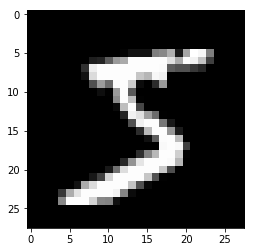

In [5]:
# Show an image
plt.imshow(trn_X[0].reshape(28, 28), cmap='gray')
trn_X.shape

## PyTorch

In [6]:
import torch

# Convert NumPy arrays to torch tensors
trn_X, trn_y, tst_X, tst_y = map(torch.tensor, (trn_X, trn_y, tst_X, tst_y))

trn_X = trn_X.type('torch.FloatTensor')
trn_y = trn_y.type('torch.FloatTensor')
tst_X = tst_X.type('torch.FloatTensor')
tst_y = tst_y.type('torch.FloatTensor')

In [7]:
type(trn_X)

torch.Tensor

### Create a neural network from scratch

In [8]:
import math

weights = torch.randn(784, 10) / math.sqrt(784)
# trailing _'s in PyTorch signifies an in-place operation
weights.requires_grad_()
# bias: kind of like a coefficient added to each term
bias = torch.zeros(10, requires_grad=True)
weights

tensor([[-0.0022,  0.0227, -0.0308,  ...,  0.0068, -0.0015,  0.0088],
        [ 0.0197,  0.0461,  0.0370,  ...,  0.0084, -0.0250, -0.0155],
        [-0.0131, -0.0086,  0.0420,  ..., -0.0112, -0.0145, -0.0125],
        ...,
        [-0.0148, -0.0392,  0.0079,  ..., -0.0910,  0.0313, -0.0857],
        [-0.0345, -0.0016, -0.0575,  ...,  0.0095, -0.0774,  0.0024],
        [ 0.0261, -0.0645,  0.0528,  ..., -0.0210, -0.0100,  0.0384]],
       requires_grad=True)

In [9]:
# Activation function
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

log_softmax(torch.tensor([0.0, 1.0]))

tensor([-1.3133, -0.3133])

In [10]:
# Activation function
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

In [11]:
# Example to understand log_softmax
test_tensor = torch.tensor([[1, 2, 3], [4, 5, 6]]).type(torch.FloatTensor)
print(test_tensor.shape)
print(test_tensor.exp())
print(test_tensor.exp().sum(-1))
print(test_tensor.exp().sum(-1).log())
print(test_tensor.exp().sum(-1).unsqueeze(-1))
print(test_tensor - test_tensor.exp().sum(-1).unsqueeze(-1))

torch.Size([2, 3])
tensor([[  2.7183,   7.3891,  20.0855],
        [ 54.5982, 148.4132, 403.4288]])
tensor([ 30.1929, 606.4401])
tensor([3.4076, 6.4076])
tensor([[ 30.1929],
        [606.4401]])
tensor([[ -29.1929,  -28.1929,  -27.1929],
        [-602.4401, -601.4401, -600.4401]])


In [12]:
# Model for learning
def model(batch):
    return log_softmax(batch @ weights + bias)
# Note: @ is the dot product operation

In [13]:
# Check to make sure dimensions line up
trn_X.shape, weights.shape

(torch.Size([60000, 784]), torch.Size([784, 10]))

In [14]:
batch_size = 64

batch = trn_X[0:batch_size]
predictions = model(batch)
predictions[0], predictions.shape

(tensor([-2.1167, -1.8724, -3.2058, -2.1228, -2.0106, -2.2342, -2.7280, -2.8415,
         -2.2118, -2.3925], grad_fn=<SelectBackward>), torch.Size([64, 10]))

In [15]:
# Loss function: the higher, the worse the model performs
def neg_log_likelihood(predictions, target):
    return -predictions[range(target.shape[0]), target.type(torch.LongTensor)].mean()

# gather: gathers values along an axis with a specified tensor as indices
# view: reshapes it to the specified shape in each dimension
def loss_2(predictions, target):
    target_indices = torch.gather(predictions, 1, target.view(-1, 1).type(torch.LongTensor))
    return (target_indices).log().mean() / (-1 * predictions.shape[0])
    # return (target @ target_indices.log() + 
    #    ((1 - target) @ (1 - target_indices)).log()).squeeze() / (-1 * predictions.shape[0])
    
def mean_squared(predictions, target):
    target_indices = torch.gather(predictions, 1, target.view(-1, 1).type(torch.LongTensor))
    return ((1 - target_indices) ** 2).sum() / predictions.shape[0]

loss_function = neg_log_likelihood

In [16]:
# Example
test_pred = torch.tensor([[0.9, 0.1, 0.5], [0.1, 0.9, 0.5]]).type(torch.FloatTensor)
test_target = torch.tensor([[2, 1]]).type(torch.FloatTensor)

loss_function(test_pred, test_target)

tensor(-0.3000)

In [17]:
print(predictions.shape, trn_y[0:batch_size].shape)
loss_function(predictions, trn_y[0:batch_size])

torch.Size([64, 10]) torch.Size([64, 1])


tensor(2.3272, grad_fn=<NegBackward>)

In [18]:
# Example to understand neg_log_likelihood
test_pred = torch.tensor([[-1, -2, -3], [-4, -5, -6]]).type(torch.FloatTensor)
test_target = torch.tensor([[1], [2]]).type(torch.FloatTensor)
print(test_pred.shape, test_target.shape)
print(range(test_target.shape[0]), test_target)
print(test_pred[range(test_target.shape[0]), test_target.type(torch.LongTensor)])
print(-test_pred[range(test_target.shape[0]), test_target.type(torch.LongTensor)].mean())
# Honestly, I don't understand their code for log_softmax and neg_log_likelihood

torch.Size([2, 3]) torch.Size([2, 1])
range(0, 2) tensor([[1.],
        [2.]])
tensor([[-2., -5.],
        [-3., -6.]])
tensor(4.)


In [19]:
# Accuracy function
def accuracy(predictions, target):
    preds = torch.argmax(predictions, dim=1)
    return (preds == target).float().mean()

In [20]:
accuracy(predictions, trn_y[0:batch_size])

tensor(0.1187)

#### Training the model

In [21]:
# print(trn_X.shape, weights.shape, bias.shape)
# predictions = model(trn_X)
# predictions.backward(torch.ones(predictions.shape))
# print(weights.grad[:, 4])
# weights.grad.zero_()

# model_loss = loss_function(model(trn_X), trn_y)
# print(model_loss)
# model_loss.backward()
# print(weights.grad.max())
# weights.grad.zero_()
# print()

# print(loss_function(model(tst_X), tst_y), accuracy(model(tst_X), tst_y))

# with torch.no_grad():
#     weights -= weights.grad * 0.1
#     print(weights.grad.max())
#     bias -= bias.grad * 0.1
#     # Set gradients to zero so gradients are correct for next loop
#     weights.grad.zero_()
#     bias.grad.zero_()

In [29]:
# Train
learning_rate = 0.5
epochs = 2
from IPython.core.debugger import set_trace

for epoch in range(epochs):
    # Run through all the data in batches
    for i in range((trn_X.shape[0] - 1) // batch_size + 1):
        start = i * batch_size
        end = start + batch_size
        batch_X = trn_X[start:end]
        batch_y = trn_y[start:end]
        predictions = model(batch_X)
        model_loss = loss_function(predictions, batch_y)

        # Calculate gradients on weights and bias
        model_loss.backward()
        # Update weights and bias, but don't calculate gradients for this process
        with torch.no_grad():
            weights -= weights.grad * learning_rate
            bias -= bias.grad * learning_rate
            # Set gradients to zero so gradients are correct for next loop
            weights.grad.zero_()
            bias.grad.zero_()

In [28]:
weights, bias

(tensor([[-0.0022,  0.0227, -0.0308,  ...,  0.0068, -0.0015,  0.0088],
         [ 0.0197,  0.0461,  0.0370,  ...,  0.0084, -0.0250, -0.0155],
         [-0.0131, -0.0086,  0.0420,  ..., -0.0112, -0.0145, -0.0125],
         ...,
         [-0.0148, -0.0392,  0.0079,  ..., -0.0910,  0.0313, -0.0857],
         [-0.0345, -0.0016, -0.0575,  ...,  0.0095, -0.0774,  0.0024],
         [ 0.0261, -0.0645,  0.0528,  ..., -0.0210, -0.0100,  0.0384]],
        requires_grad=True),
 tensor([-0.0665,  0.1674,  0.1357,  0.0102, -0.0967, -0.1344, -0.0457,  0.0813,
         -0.0521,  0.0009], requires_grad=True))

In [24]:
loss_function(model(tst_X), tst_y), accuracy(model(tst_X), tst_y)

(tensor(2.5944, grad_fn=<NegBackward>), tensor(0.0965))